# Gathering Data

In [3]:
import pandas as pd
import tweepy
import numpy as np
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import scipy as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# twitter archive downloaded manually and read
archive_df=pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [5]:
# images prediction database downloaded automatically and saved as a tsv file
link = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
images = requests.get(link)
file=open('images.tsv', "w")
file.write(images.text)

335079

In [6]:
# openeing images file
images_df = pd.read_csv('images.tsv', sep='\t')
images_df.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [51]:
# setting up api querying and testing if it works

consumer_key = "XXXX"
consumer_secret = "XXXX" 
access_key = "XXXX"
access_secret = "XXXX"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

public_tweet = api.get_status(archive_df.tweet_id[1000], tweet_mode = 'extended')
content = public_tweet._json
content.keys()
content['retweet_count']
content['favorite_count']




2081

In [75]:
# creating text file and dumping output of api querying
if not os.path.isfile('tweet_json.txt'):
    print("file created")
    errors = []
    count=0
    error_no=0
    with open ('tweet_json.txt', 'w') as file:
            for tweet_id in archive_df['tweet_id']:
                count = count + 1
                print(str(count) + 'out of ' + str(len(archive_df)))
                try:
                    status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                    json.dump(status._json, file)
                    file.write('\n')
                except Exception as e:
                    error_no=error_no + 1
                    print(str(error_no) + "errors")
                    print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                    errors.append(tweet_id)


1116out of 2356
1117out of 2356
1118out of 2356
1119out of 2356
1120out of 2356
1121out of 2356
1122out of 2356
1123out of 2356
1124out of 2356
1125out of 2356
1126out of 2356
1127out of 2356
1128out of 2356
1129out of 2356
1130out of 2356
1131out of 2356
1132out of 2356
1133out of 2356
1134out of 2356
1135out of 2356
1136out of 2356
1137out of 2356
1138out of 2356
1139out of 2356
1140out of 2356
1141out of 2356
1142out of 2356
1143out of 2356
1144out of 2356
1145out of 2356
1146out of 2356
1147out of 2356
1148out of 2356
1149out of 2356
1150out of 2356
1151out of 2356
1152out of 2356
1153out of 2356
1154out of 2356
1155out of 2356
1156out of 2356
1157out of 2356
1158out of 2356
1159out of 2356
1160out of 2356
1161out of 2356
1162out of 2356
1163out of 2356
1164out of 2356
1165out of 2356
1166out of 2356
1167out of 2356
1168out of 2356
1169out of 2356
1170out of 2356
1171out of 2356
1172out of 2356
1173out of 2356
1174out of 2356
1175out of 2356
1176out of 2356
1177out of 2356
1178out 

In [66]:
print(len(errors))

2356


In [7]:
#reading every line and converting it to a dictionary then saving all those dictionaries in a list
tweet_list=[]
file=open('tweet_json.txt')
for line in file:
    tweet = json.loads(line)
    tweet_list.append(tweet)

In [8]:
#testing the resulting list
print(tweet_list[10]['retweet_count'])

6478


In [9]:
#converting the list to a dataframe
tweets_df=pd.DataFrame(tweet_list)
api_df = tweets_df[['id', 'full_text', 'favorite_count', 'retweet_count']]
api_df.head()

,id,full_text,favorite_count,retweet_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35324,7456
1,892177421306343426,This is Tilly. She's just checking pup on you....,30582,5534
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,23007,3660
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38619,7625
4,891327558926688256,This is Franklin. He would like you to stop ca...,36894,8228


In [10]:
"""
Dropping all retweeted and reply tweets and keeping only original tweets in our archive_df dataframe. This is a data cleaning issue that I chose to rectify early on in the assessment phase
"""

archive_df.drop(archive_df.loc[archive_df['retweeted_status_id'].notnull()].index, inplace=True)
archive_df.drop(archive_df.loc[archive_df['in_reply_to_status_id'].notnull()].index, inplace=True)


In [11]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

In [13]:
archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2041,671542985629241344,NaN,NaN,2015-12-01 04:14:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is JD (stands for ""just dog""). He's like ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/671542985...,10,10,JD,None,None,None,None
704,785872687017132033,NaN,NaN,2016-10-11 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rusty. He appears to be rather h*ckin flu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785872687...,12,10,Rusty,None,None,None,None
1126,729854734790754305,NaN,NaN,2016-05-10 02:05:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Ollie. He conducts this train. He...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/729854734...,11,10,Ollie,None,None,None,None
2055,671362598324076544,NaN,NaN,2015-11-30 16:18:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tanner. He accidentally dropped all hi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671362598...,11,10,Tanner,None,None,None,None
1188,718454725339934721,NaN,NaN,2016-04-08 15:05:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pic is old but I hadn't seen it until tod...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718454725...,13,10,None,None,None,None,None


In [15]:
#some names seem to be incorrectly parsed
archive_df.name.value_counts()

None         603
a             55
Charlie       11
Lucy          11
Oliver        10
            ... 
Coopson        1
Heinrich       1
Berkeley       1
Snoop          1
Alejandro      1
Name: name, Length: 955, dtype: int64

In [16]:
"""
Through visual assessment it was discovered that a lot of tweets starting with "This is a" have had their name incorrectly parsed. I applied variations of the following code to try to identify the reason behind that and if it could be rectified
"""

archive_df.text[archive_df['text'].str.contains("This is a")][1002]

'This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW'

In [17]:
#timestamp column has unnecessary characters
archive_df.timestamp.head(3)

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
Name: timestamp, dtype: object

In [18]:
archive_df.rating_numerator.value_counts()

12      486
10      436
11      413
13      287
9       153
8        98
7        52
14       38
5        34
6        32
3        19
4        16
2         9
1         5
26        1
44        1
165       1
24        1
60        1
50        1
144       1
80        1
84        1
88        1
121       1
204       1
420       1
1776      1
27        1
45        1
75        1
99        1
0         1
Name: rating_numerator, dtype: int64

In [19]:
#some numerator rankings don't make sense, the code below was executed to try to identify the root cause
archive_df.text[archive_df.rating_numerator ==26][1712]

'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD'

In [20]:
archive_df.rating_denominator.value_counts()

10     2080
50        3
11        2
80        2
7         1
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

In [21]:
"""
17 tweets have either had their ratings improperly parsed, have a missing rating or an off-scale rating
"""
len(archive_df.text[archive_df.rating_denominator !=10])

17

In [22]:
all_stages = pd.Series(list(archive_df['doggo']) + list(archive_df['floofer']) + list(archive_df['pupper']) + list(archive_df['puppo']))

In [23]:
all_stages.value_counts()

None       8041
pupper      230
doggo        83
puppo        24
floofer      10
dtype: int64

In [24]:
archive_df.loc[archive_df.timestamp.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## images_df data assessment
### data quality issues:
1. There are 324 tweets with images that don't have dogs (some of these images do have dogs but the algorithm failed to identify them)

### data tidiness issues:
1. images_df should be merged with archive_df

In [25]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [67]:
#images_df.loc[(images_df.p3_dog.notnull())]

In [26]:
Not_dogs = images_df.loc[(images_df['p1_dog'] == False) & (images_df['p2_dog'] == False) & (images_df['p3_dog'] == False)]

In [27]:
len(Not_dogs)

324

## Assessment Summary
### Data quality issues:
1. dataframe includes retweets
2. dataframe includes reply tweets
3. 680 tweets without names and 55 with an 'a' name or other incorrect 1 or 2 character names
4. 22 tweets have rating denominators higher than 10
5. a few rating numerators seem to be incorrect
6. incorrect datetime column data type
7. dataframe includes tweets with no images
8. Timestamp column includes (+0000) at the end of the string
9. Date column datatype should be datetime
### Data tidiness issues:
1. Dog stage are over 4 different columns instead of 1 and some tweets have 2 stages
2. timestamp column includes date and time and should be split over 2 columns
3. Drop columns we don't need


# Data Cleaning
## Tidiness
1. timestamp column includes date and time and should be split over 2 columns
2. Drop unused columns
3. Dog stage are over 4 different columns instead of 1

## Quality
1. remove the 1 syllable names 'a'
2. incorrect datatype for date column
3. drop tweets that have no dog images
4. tweets have incorrect rating denominators
5. some rating numerators are incorrect

** Fixed while tidying **

6. Some tweets have 2 dog stages
7. Datetime column includes unwanted characters (+0000)

** Fixed while assessing **

8. Dataframe includes retweets
9. Dataframe includes replies


In [28]:
archive_df_clean=archive_df.copy()
images_df_clean = images_df.copy()

** issue: timestamp column includes date and time and should be split over 2 columns **

### Define
Splitting timestamp column to reflect date only and add another column for time. Removing unnecessary characters

### Code

In [29]:
archive_df_clean['timestamp'] = archive_df_clean['timestamp'].map(lambda x: x.lstrip('+-').rstrip('+0000'))

In [30]:
new_timestamp = archive_df_clean['timestamp'].str.split(" ", n = 1, expand = True) 

In [31]:
archive_df_clean['date']=new_timestamp[0]
archive_df_clean['time']=new_timestamp[1]

In [32]:
archive_df_clean.drop(columns=['timestamp'], inplace=True)

### test

In [33]:
archive_df_clean.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,2017-08-01,16:23:56
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,2017-08-01,00:17:27
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,2017-07-31,00:18:03
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,2017-07-30,15:58:51
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,2017-07-29,16:00:24


In [34]:
len(archive_df_clean)

2097

**Issue: Drop unused columns **
### Define
Dropping unused columns using the pandas drop method

### Code

In [36]:
archive_df_clean = archive_df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

### Test

In [37]:
archive_df_clean.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'date', 'time'],
      dtype='object')

**Issue: Dog stage are over 4 different columns instead of 1 ** 
### Define
create 1 dog stage category columns instead of the current 4

### Code

In [39]:
#Fix None entries
archive_df_clean.doggo.replace('None', '', inplace=True)
archive_df_clean.floofer.replace('None', '', inplace=True)
archive_df_clean.pupper.replace('None', '', inplace=True)
archive_df_clean.puppo.replace('None', '', inplace=True)

In [40]:
archive_df_clean['dog_stage'] = archive_df_clean.doggo + archive_df_clean.floofer + archive_df_clean.pupper + archive_df_clean.puppo

In [42]:
#handle multiple stages
archive_df_clean.loc[archive_df_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
archive_df_clean.loc[archive_df_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, pupper'
archive_df_clean.loc[archive_df_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, pupper'

# handle missing values
archive_df_clean.loc[archive_df_clean.dog_stage == '', 'dog_stage'] = np.nan



In [33]:
"""
archive_df_clean = pd.melt(archive_df_clean, id_vars=['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'date', 'time'], var_name='stage', value_name='dog_stage')
archive_df_clean = archive_df_clean.drop('stage', axis=1)
archive_df_clean = archive_df_clean.sort_values(by=['tweet_id'])
"""

### Test

In [40]:
len(archive_df_clean)

2097

In [44]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   source              2097 non-null   object
 2   text                2097 non-null   object
 3   expanded_urls       2094 non-null   object
 4   rating_numerator    2097 non-null   int64 
 5   rating_denominator  2097 non-null   int64 
 6   name                2097 non-null   object
 7   doggo               2097 non-null   object
 8   floofer             2097 non-null   object
 9   pupper              2097 non-null   object
 10  puppo               2097 non-null   object
 11  date                2097 non-null   object
 12  time                2097 non-null   object
 13  dog_stage           336 non-null    object
dtypes: int64(3), object(11)
memory usage: 325.7+ KB


 ** Extra Issue:  merge the dataframe with archive_df to produce an archive dataframe only containing tweets with that have images **

### Define
using the merge pandas method to inner join both dataframes on the tweet_id column

### Code

In [45]:
#merging all dataframes together, tweets with no images are dropped
archive_df_clean = archive_df_clean.merge(images_df_clean, on='tweet_id')
archive_df_clean = archive_df_clean.merge(api_df, left_on='tweet_id', right_on='id')

In [46]:
#Dropping full text and id columns due to duplication post merger
archive_df_clean.drop(['full_text','id'], axis=1, inplace=True)

### test

In [47]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1964 non-null   int64  
 1   source              1964 non-null   object 
 2   text                1964 non-null   object 
 3   expanded_urls       1964 non-null   object 
 4   rating_numerator    1964 non-null   int64  
 5   rating_denominator  1964 non-null   int64  
 6   name                1964 non-null   object 
 7   doggo               1964 non-null   object 
 8   floofer             1964 non-null   object 
 9   pupper              1964 non-null   object 
 10  puppo               1964 non-null   object 
 11  date                1964 non-null   object 
 12  time                1964 non-null   object 
 13  dog_stage           302 non-null    object 
 14  jpg_url             1964 non-null   object 
 15  img_num             1964 non-null   int64  
 16  p1    

## Quality issues

**issue remove the 1 syllable names 'a' **

### Define

### Code

In [48]:
archive_df_clean['name']=archive_df_clean['name'].str.replace('a', 'None', case=False)

### Test

In [56]:
archive_df_clean.name.value_counts()

None          446
Cooper         10
Tucker          9
Lucy            9
ChNonerlie      9
             ... 
BungNonelo      1
Kulet           1
Ron             1
Obi             1
HNonelo         1
Name: name, Length: 848, dtype: int64

** issue:  incorrect datatype for date column **

### Define
fix data type with datetime


### Code

In [50]:
archive_df_clean.date = pd.to_datetime(archive_df_clean.date)

### Test

In [51]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1964 non-null   int64         
 1   source              1964 non-null   object        
 2   text                1964 non-null   object        
 3   expanded_urls       1964 non-null   object        
 4   rating_numerator    1964 non-null   int64         
 5   rating_denominator  1964 non-null   int64         
 6   name                1964 non-null   object        
 7   doggo               1964 non-null   object        
 8   floofer             1964 non-null   object        
 9   pupper              1964 non-null   object        
 10  puppo               1964 non-null   object        
 11  date                1964 non-null   datetime64[ns]
 12  time                1964 non-null   object        
 13  dog_stage           302 non-null    object      

** Issue: drop tweets that have no dog images **
### Define:
Drop tweets with no dog images using pandas loc 


In [52]:
Not_dogs = archive_df_clean.loc[(archive_df_clean['p1_dog'] == False) & (archive_df_clean['p2_dog'] == False) & (archive_df_clean['p3_dog'] == False)]

### Code

In [53]:
archive_df_clean.drop(Not_dogs.index, inplace=True)

### Test

In [54]:
archive_df_clean.loc[(archive_df_clean['p1_dog'] == False) & (archive_df_clean['p2_dog'] == False) & (archive_df_clean['p3_dog'] == False)]

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count


In [55]:
len(archive_df_clean)

1659

** Issue: tweets have incorrect rating denominators **

### Define

set any incorrect denominator to 10

### Code

In [57]:
archive_df_clean.rating_denominator=np.where((archive_df_clean.rating_denominator!=10),10, archive_df_clean.rating_denominator)

### Test

In [58]:
#checking the series for values not equal to 10

archive_df_clean.rating_denominator[archive_df_clean.rating_denominator!=10]

Series([], Name: rating_denominator, dtype: int64)

In [59]:
#double checking by making sure that only values equal to 10 are present in the series
archive_df_clean.rating_denominator.value_counts()

10    1659
Name: rating_denominator, dtype: int64

** Issue: some rating numerators are incorrect **

### Define

Only 1 is fixed for observational purposes

### Code

In [62]:
#get index number of tweet highlighted in assessment phase after dataframe was cleaned and merged
archive_df_clean.text[archive_df_clean.rating_numerator ==26][1353]

'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD'

In [63]:
"""
replaced 26 with 12
"""

archive_df_clean['rating_numerator']=archive_df_clean['rating_numerator'].replace(26, 12)

### Test

In [64]:
archive_df_clean.rating_numerator.value_counts()

12     420
10     357
11     352
13     217
9      132
8       68
7       32
14      21
6       16
5       14
4        7
3        5
2        2
1        1
165      1
144      1
24       1
27       1
44       1
45       1
50       1
60       1
75       1
80       1
84       1
88       1
99       1
121      1
0        1
Name: rating_numerator, dtype: int64

In [65]:
archive_df_clean

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,30582,5534
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Nonerchie,,,,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,23007,3660
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,DNonerlNone,,,,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,38619,7625
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,FrNonenklin,,,,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,36894,8228
5,891087950875897856,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,,,,...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,18616,2753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,666049248165822465,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,,,,...,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,95,39
1960,666044226329800704,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,None,,,,...,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,263,124
1961,666033412701032449,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,None,,,,...,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,108,39
1962,666029285002620928,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,None,,,,...,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,118,41


In [66]:
archive_df_clean.drop(columns=['doggo','floofer', 'pupper', 'puppo'], inplace=True)

In [67]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1659 entries, 1 to 1963
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1659 non-null   int64         
 1   source              1659 non-null   object        
 2   text                1659 non-null   object        
 3   expanded_urls       1659 non-null   object        
 4   rating_numerator    1659 non-null   int64         
 5   rating_denominator  1659 non-null   int64         
 6   name                1659 non-null   object        
 7   date                1659 non-null   datetime64[ns]
 8   time                1659 non-null   object        
 9   dog_stage           256 non-null    object        
 10  jpg_url             1659 non-null   object        
 11  img_num             1659 non-null   int64         
 12  p1                  1659 non-null   object        
 13  p1_conf             1659 non-null   float64     

In [72]:
# export cleaned dataframe to sqlite database

from sqlalchemy import create_engine
import sqlite3
engine = create_engine('sqlite:///C:\\Users\\Alykh\\OneDrive\\Desktop\\Dogs.db', echo=False)
sqliteconnection = sqlite3.connect('Dogs.db')
cursor = sqliteconnection.cursor()
print("conntected to SQL")
archive_df_clean.to_sql('twitter_archive_master', con=sqliteconnection, if_exists='append')
cursor.close()

conntected to SQL


# Analysis

## First Insight

pupper is the most favored dog stage, garnering 1.2mn likes

In [73]:
archive_df_clean.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,time,dog_stage,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,2017-08-01,00:17:27,NaN,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,30582,5534
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Nonerchie,2017-07-31,00:18:03,NaN,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,23007,3660
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,DNonerlNone,2017-07-30,15:58:51,NaN,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,38619,7625
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,FrNonenklin,2017-07-29,16:00:24,NaN,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,36894,8228
5,891087950875897856,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,2017-07-29,00:08:17,NaN,...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,18616,2753


In [74]:
dog_stages = archive_df_clean[archive_df_clean.dog_stage.notnull()]

In [75]:
dog_stages.dog_stage.value_counts()

pupper           166
doggo             53
puppo             21
doggo, pupper      9
floofer            7
Name: dog_stage, dtype: int64

In [76]:
dog_stages = archive_df_clean.groupby(['dog_stage']).sum()

In [77]:
dog_stages

,tweet_id,rating_numerator,rating_denominator,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,favorite_count,retweet_count
dog_stage,,,,,,,,,,,,
doggo,4.240933e+19,631.0,530.0,68.0,30.344305,47.0,8.684343,48.0,3.249808,44.0,989852.0,334869.0
"doggo, pupper",7.122415e+18,102.0,90.0,10.0,6.302706,9.0,1.015716,8.0,0.461305,7.0,157751.0,49207.0
floofer,5.365860e+18,84.0,70.0,8.0,4.264427,7.0,1.087233,7.0,0.335976,6.0,82336.0,29490.0
pupper,1.197287e+20,1820.0,1660.0,215.0,105.165137,144.0,21.946712,147.0,9.151349,142.0,1140247.0,347899.0
puppo,1.701699e+19,251.0,210.0,31.0,15.158874,19.0,2.914830,20.0,0.924957,21.0,428588.0,116930.0


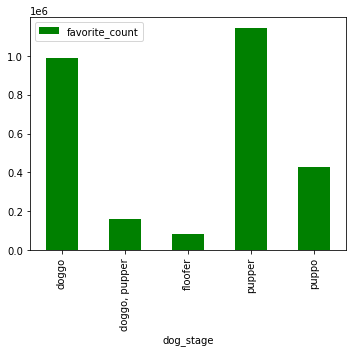

In [96]:
insight1 = dog_stages.plot(y='favorite_count', kind='bar', color='g', figsize=(5,5))
plt.tight_layout()

In [97]:
insight1.figure.savefig('insight1.png')

## Second Insight
Tweets got more popular over time, with more recent tweets garnering a higher number of likes

In [80]:
normalized_favorite_count = archive_df_clean[archive_df_clean['favorite_count'].between(archive_df_clean['favorite_count'].quantile(.15), archive_df_clean['favorite_count'].quantile(.80))]

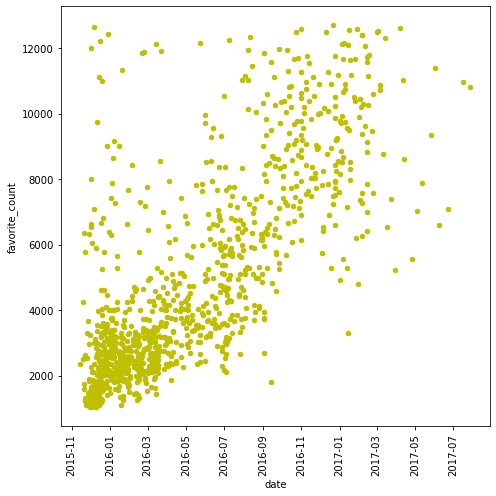

In [98]:
import matplotlib.pyplot as plt
insight2 = normalized_favorite_count.plot(x='date', y='favorite_count', kind='scatter', color='y', figsize=(7,7))
plt.xticks(rotation=90)
plt.tight_layout()

In [99]:
insight2.figure.savefig('insight2.png')

## Third Insight

the Golden retiriever is the most popular breed 

In [83]:
popular_breed1 = archive_df_clean.p1.value_counts()
popular_breed2 = archive_df_clean.p2.value_counts()
popular_breed3 = archive_df_clean.p2.value_counts()

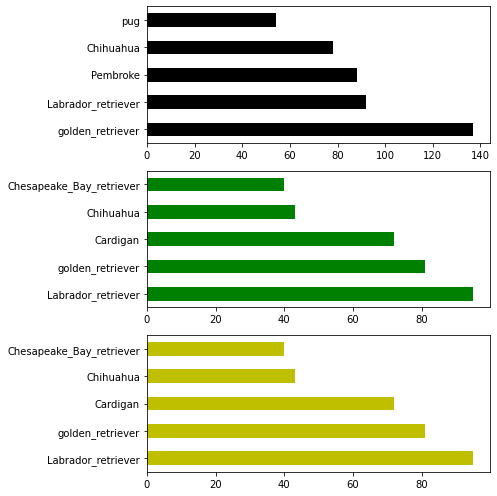

In [100]:
figure, axes = plt.subplots(3, 1, figsize=(7,7))
popular_breed1.head(5).plot(ax=axes[0], kind='barh', color='k')
popular_breed2.head(5).plot(ax=axes[1], kind='barh', color='g')
popular_breed3.head(5).plot(ax=axes[2], kind='barh', color='y')
plt.tight_layout()

In [101]:
figure.savefig('insight3.png')